# Modelos Geocéntricos
Agrego aquí que amé la frase "Linear regression is the geocentric model of applied statistics".

In [86]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


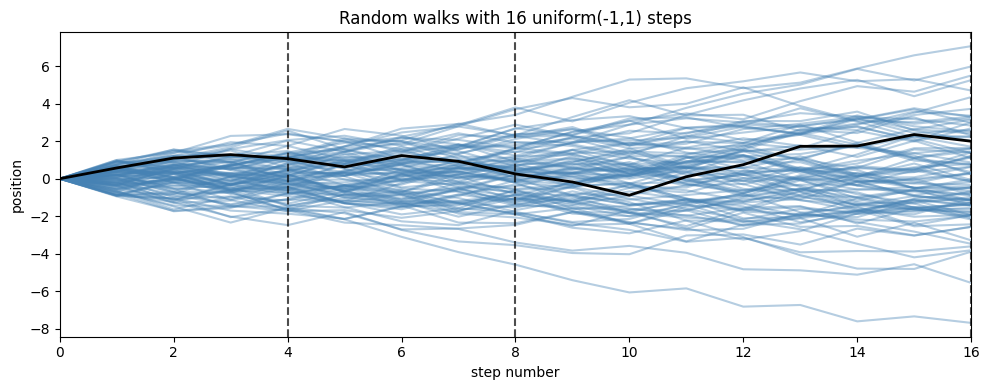

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_walks = 100
steps = 16

raw = np.random.uniform(-1, 1, size=(n_walks, steps))

walks = np.hstack([
    np.zeros((n_walks, 1)), # Todos inician en cero
    np.cumsum(raw, axis=1)  # luego vamos sumando en forma cumulativa por cada paso.
])

fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos las trayectorias
for i in range(n_walks-1): # excepto la última
    ax.plot(range(steps + 1), walks[i], alpha=0.4, color="steelblue")

ax.plot(range(steps + 1), walks[-1],  linewidth=2, color="black")

# dashed vertical lines at 4, 8, 16 steps
for v in [4, 8, 16]:
    ax.axvline(v, ls='--', color='black', alpha=0.7)

ax.set_xlabel("step number")
ax.set_ylabel("position")
ax.set_xlim(0, steps)
ax.set_title("Random walks with 16 uniform(-1,1) steps")

plt.tight_layout()
plt.show()


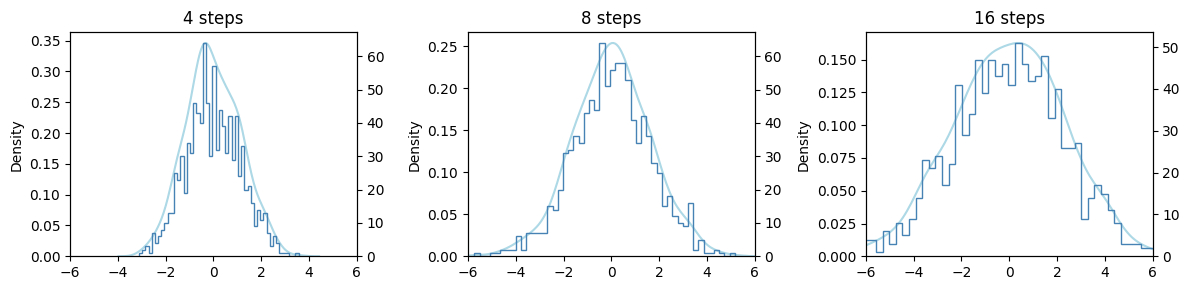

In [56]:

def random_walks(steps):
    return (
        np.random
        .uniform(
            -1, 1,
            size=(1000, steps),
        ).sum(axis=1)
    )

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, steps in zip(axes, (4, 8, 16)):
    pos = random_walks(steps)

   
    sns.kdeplot(pos, ax=ax, color='lightblue')
    ax.set_title(f"{steps} steps")
    ax.set_xlim(-6, 6)
    
    ax2 = ax.twinx()
    ax2.hist(pos, bins=50, histtype='step', color='steelblue')
plt.tight_layout()
plt.show()


## Loading data from rethinking directly

In [193]:
%%R -o df
library(rethinking)

data(Howell1)
df = Howell1


In [109]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
df: pd.DataFrame

## Regression simulation

$W_i = \beta H_i + U_i$

$U_i \sim Normal(0, \sigma)$ 

$H_i \sim Uniform(130, 170)$

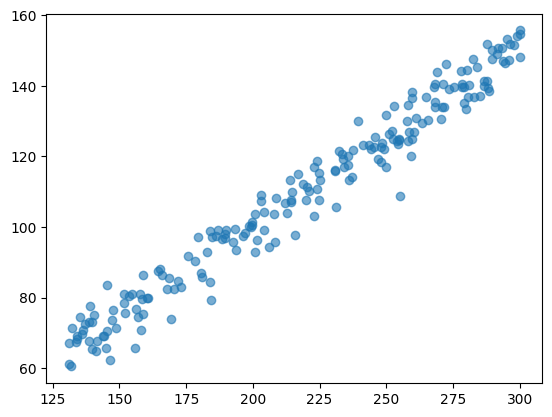

In [131]:
def sim_weight(H, b, sd):
    U = stats.norm.rvs(0, sd, size=len(H))
    W = b * H + U
    return W

H = stats.uniform.rvs(130, 170, size=200)
W = sim_weight(H, 0.5, 5)
plt.scatter(H, W, alpha=0.6)

In [265]:
import pymc as pm
import arviz as az
b = 0.5
sd = 5
with pm.Model() as model:
    Ui = pm.Normal('Ui', 0, sd)
    Hi = pm.Uniform('Hi', 130, 170)
    #beta = pm.Normal('beta', 0, 2)
    Wi = pm.Deterministic('Wi', b*Hi+Ui)
    idata = pm.sample(nuts_sampler='blackjax', progressbar=0)

pm.summary(idata)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ui,-0.063,4.951,-8.645,9.718,0.083,0.078,3548.0,3040.0,1.0
Hi,149.965,11.482,131.032,168.412,0.201,0.123,2878.0,2211.0,1.0
Wi,74.920,7.488,61.547,88.565,0.129,0.104,3343.0,2841.0,1.0


array([[<Axes: >, None],
       [<Axes: xlabel='Hi', ylabel='Wi'>, <Axes: >]], dtype=object)

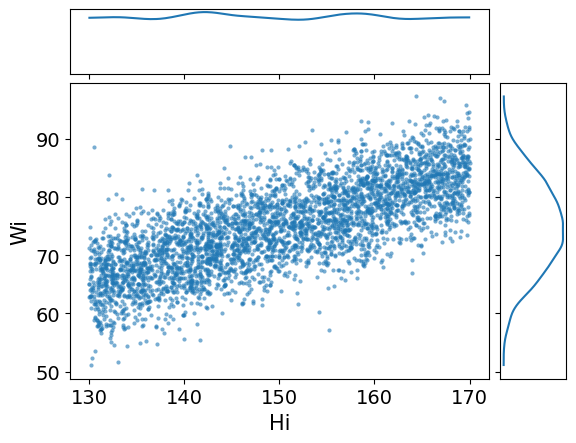

In [266]:
az.plot_pair(
    idata, 
    var_names=[ 'Hi', 'Wi',], 
    scatter_kwargs={'alpha': 0.6}, 
    marginals=True,
)


## Estimator
$E(W_i|H_i)= \alpha + \beta H_i$

Alfa es el intercepto, beta la pendiente.
El objetivo es el valor esperado del peso condicionado por la altura.

### Distribución posterior:

$$
Pr(\alpha, \beta, \sigma | H_i, W_i) = \frac{Pr(W_i|H_i, \alpha, \beta, \sigma)Pr(\alpha, \beta, \sigma)}{Z}
$$

A la izquierda la distribución posterior para la línea de la regresión, condicionado al peso y talla.
Z es la constante de normalización.

### Modelo:

$W_i \sim Normal(\mu, \sigma)$

$\mu_i = \alpha + \beta H_i$


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


### Quap
#### R

In [194]:
%%R
W <- df$weight
H <- df$height

m3.1 <- quap(
    alist(
        W ~ dnorm(mu, sigma),
        mu <- a + b*H,
        a ~ dnorm(0, 10),
        b ~ dunif(0, 1),
        sigma ~ dunif(0, 10)
    ), data=list(W=W, H=H)
)
precis(m3.1)

        mean   sd   5.5%  94.5%
a     -33.36 1.09 -35.09 -31.62
b       0.50 0.01   0.49   0.51
sigma   4.98 0.15   4.74   5.23


#### Python

In [195]:
with pm.Model() as model:
    a = pm.Normal('a', 0, 10)
    b = pm.Uniform('b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + b*df['height'])
    W = pm.Normal('W', mu, sigma, observed=df['weight'])
    mp = pm.find_MAP(progressbar=0)
    hess = pm.find_hessian(mp, negate_output=False)
    # si negate output no es True, se genera una advertencia
    covariance_matrix = np.linalg.inv(-hess)
    stds = np.sqrt(np.diag(covariance_matrix))

print()
result = pd.DataFrame(columns=['mean', 'std', '5.5%', '94.5%'])
vars = ['a', 'b', 'sigma']

for i, var in enumerate(vars):
    # A diferencia del capítulo 2
    # tenemos ahora 3 variables clave por lo que tenemos que buscarlas
    # de forma independiente
    map_point = float(mp[var])
    sd = stds[i]
    lo, hi = stats.norm.ppf([0.055, 0.945], loc=map_point, scale=sd)
    result.loc[var] = map_point, sd, lo, hi
result.round(2)

,mean,std,5.5%,94.5%
a,-33.36,1.09,-35.09,-31.62
b,0.50,0.03,0.45,0.55
sigma,4.98,0.06,4.89,5.08


#### Modelo MCMC

In [279]:

with pm.Model() as model:
    a = pm.Normal('a', 0, 10)
    b = pm.Uniform('b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + b*df['height'])
    W = pm.Normal('W', mu, sigma, observed=df['weight'])
    idata = pm.sample(nuts_sampler='blackjax', progressbar=0)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, progressbar=0)
    prior_predictive = pm.sample_prior_predictive(samples=500, random_seed=42)
    idata.extend(prior_predictive)

az.summary(idata, var_names=['a', 'b', 'sigma'])

Sampling: [W]
Sampling: [W, a, b, sigma]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-33.352,1.076,-35.371,-31.337,0.034,0.024,989.0,1307.0,1.0
b,0.499,0.008,0.485,0.514,0.000,0.000,989.0,1276.0,1.0
sigma,5.007,0.150,4.732,5.291,0.004,0.003,1677.0,1651.0,1.0


<Axes: xlabel='W'>

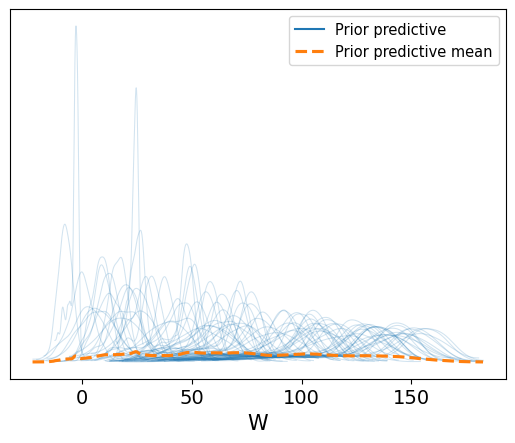

In [217]:
az.plot_ppc(
    idata,
    group="prior", 
    num_pp_samples=100,
    random_seed=42
)

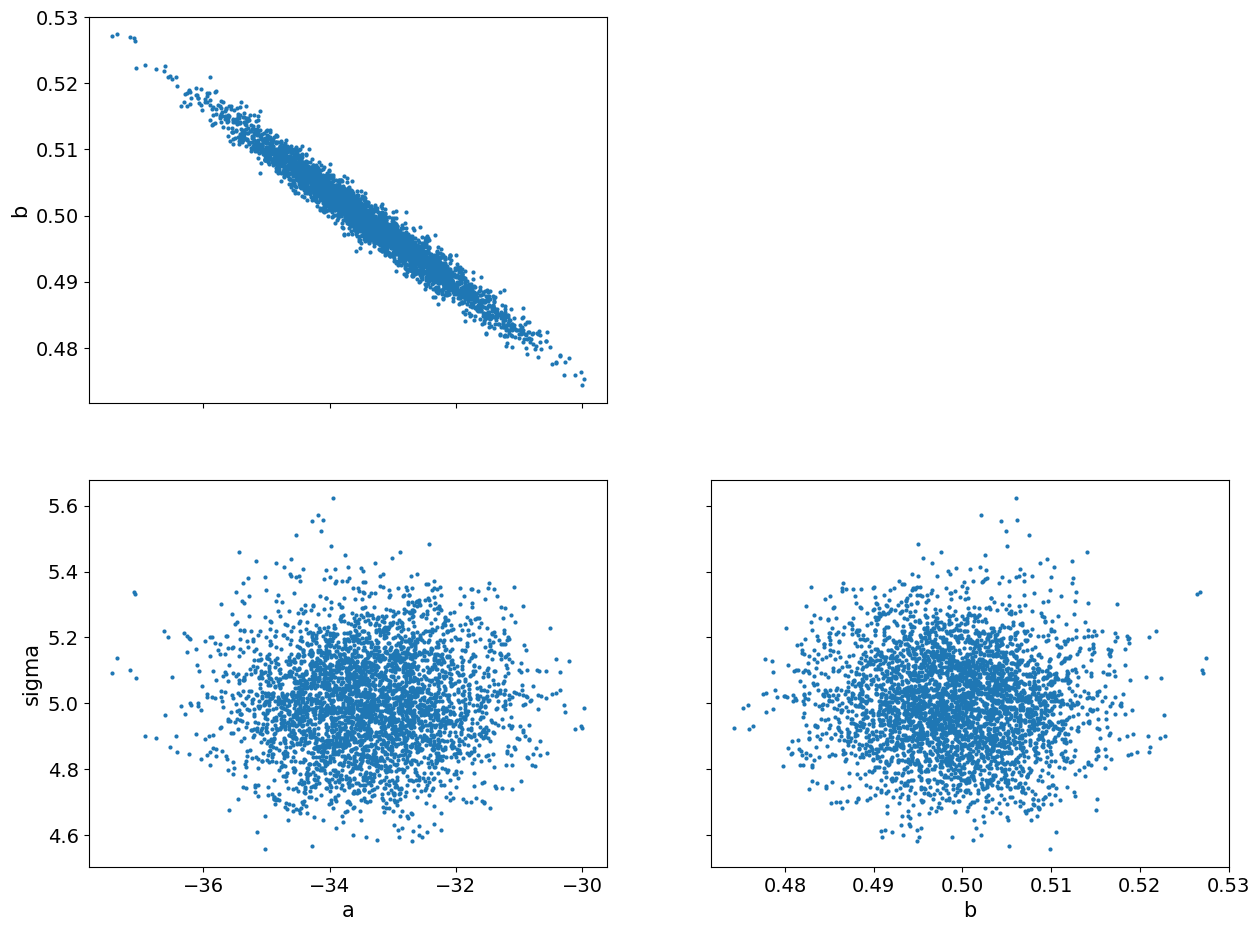

In [223]:
az.plot_pair(idata, var_names=['a', 'b', 'sigma']);

<Axes: xlabel='W'>

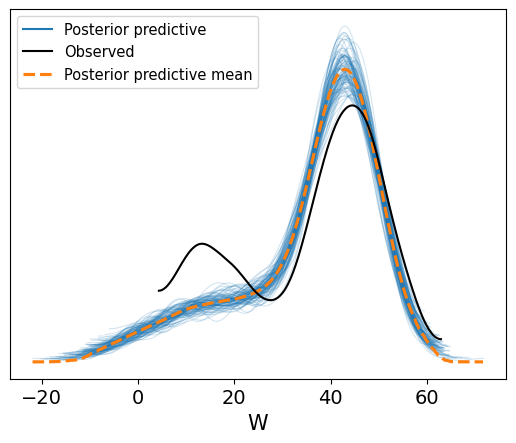

In [269]:
az.plot_ppc(idata, num_pp_samples=100,)

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

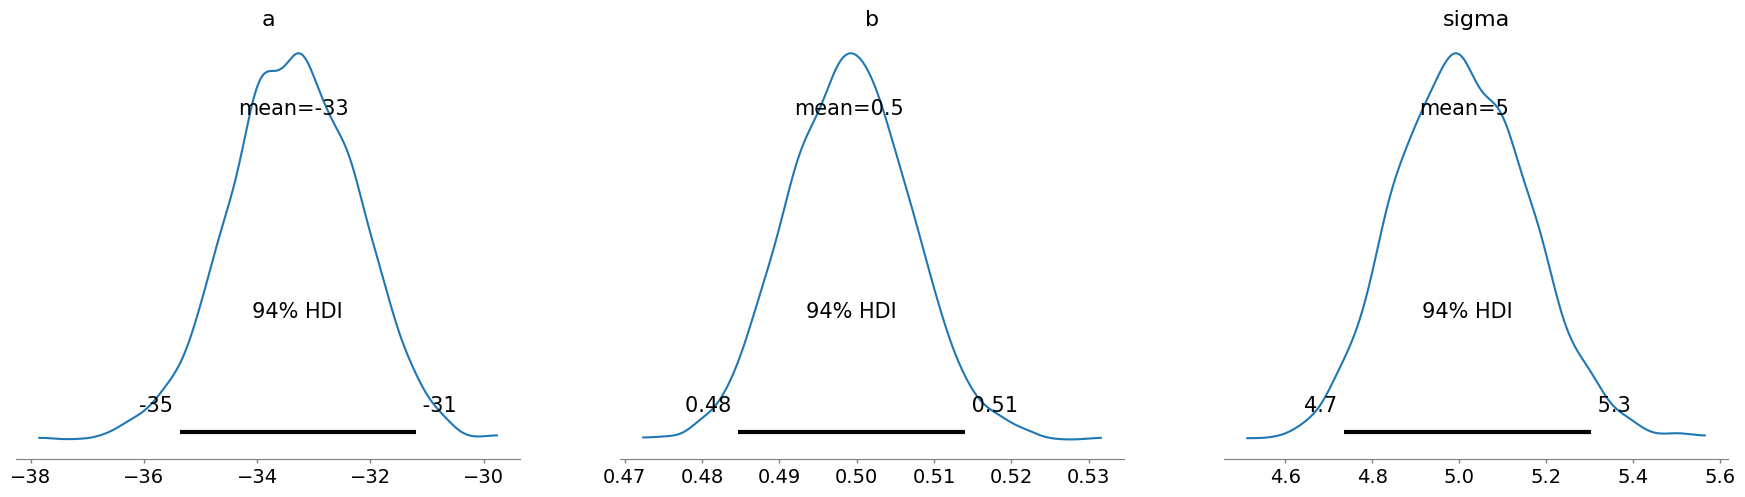

In [172]:
pm.plot_posterior(idata, var_names=['a', 'b', 'sigma'])